In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

from sklearn.utils import shuffle

from IPython.display import Math, Image
from IPython import display
import os
import sys

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

# ######### En Colab ################
# ATTENTION: LAISSEZ CE CODE COMMENTE
# si le notebook est executé en local
# ###################################
# from google.colab import drive
# drive.mount('/content/drive')

# # # ********** A modifier ************
# MY_PATH = "TP-GAN_v1"
# # #************************************
# path_dir = os.path.join("/content/drive/My Drive", MY_PATH)

# sys.path.append(os.path.join(path_dir, "config"))
# ################################

# ######## En local ##################
# ATTENTION: LAISSEZ CE CODE COMMENTE
# si le notebook est executé en Colab
# ####################################
path_dir = os.getcwd()
# ##############################

print("TF version: ", tf.__version__)  # verifier d'avoir la version 2.3.0

TF version:  2.2.0


## Une introduction à l'entrainement de réseaux de neurones avec Tensor Flow 2

L'objectif de ce notebook est d'introduire l'architecture des réseaux de neurones avec Tensorflow 2 au travers d'un exemple simple de fonction $f$ à approcher telle que 

$$f(x) = x^2, \qquad x\in[-1,1]. $$

On partira d'une situation extrêmement (voir excessivement) simple: un réseau de neurones $\hat{f}:\mathbb R \to \mathbb R$ à 1 couche cachée avec 1 seul neurone et une fonction ReLU $\sigma$:

$$\hat{f}(x) = b^{(2)} + w^{(2)}\sigma\left(w^{(1)}x + b^{(1)} \right).$$

C'est un modèle contenant quatre paramètres à déterminer: $w^{(1)}, b^{(1)}$ et $w^{(2)}, b^{(2)}$.

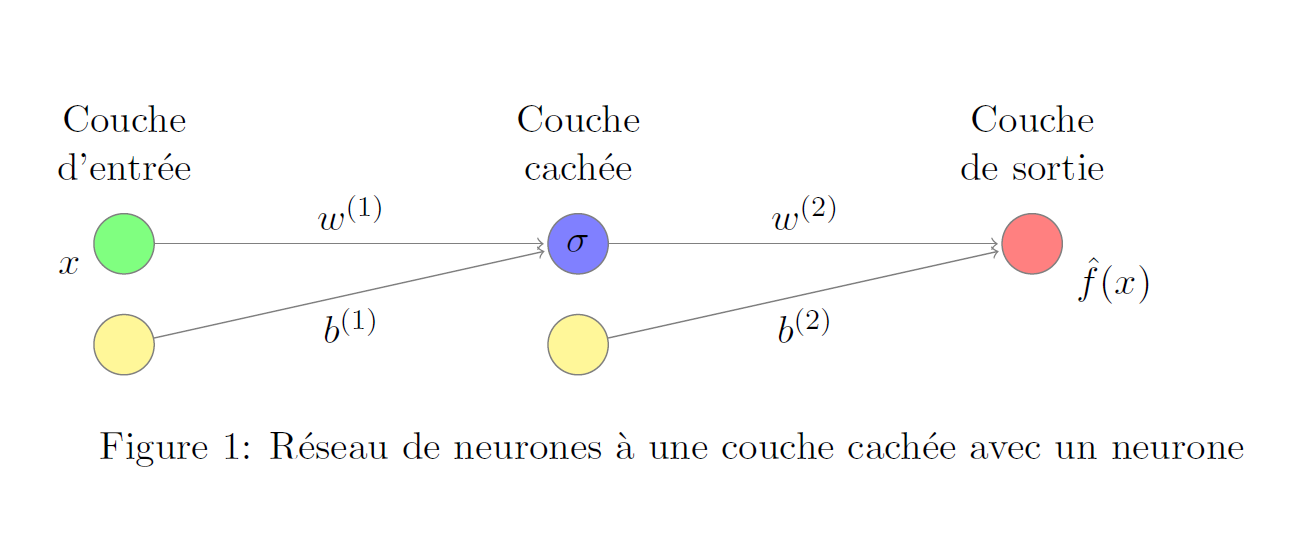

In [2]:
Image(filename=os.path.join(path_dir, "config", "screen", "nn_graph.png"), width=900, height=400)

**Fonction de coût à minimiser**

Etant donné $n$ points $(x_i)_{i = 1, \dots, n}$ et $n$ evaluations de la fonction $f(x_i)$, on souhaite minimiser la fonction de coût

$$\mathcal L(X, \theta) = \frac{1}{n}\sum_{i=1}^n \left( f(x_i) - \hat{f}_\theta(x_i)\right)^2$$

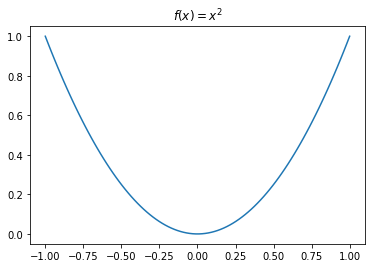

In [3]:
N_DATA = 100

X = np.linspace(-1, 1, N_DATA, dtype=np.float32).reshape(-1,1)
y = X ** 2

plt.plot(X, y)
_ = plt.title("$f(x)=x^2$")

### Construction du réseau de neurones

In [4]:
def build_model(dim_data, n_neurons):
    """
    Construction d'un réseau de neurones

    Parameters
    ----------
    dim_data: int
        dimension des données en entrée du réseau, dim(x_i)
    n_neurons: int
        nombre de neurones dans la couche cachée

    Returns:
    -------
    object
        Réseau de neurones
    """
    # On fixe l'aléa dans l'initialisation aléatoire des paramètres du réseau
    # Pour que tout le monde ait les memes résultats
    tf.random.set_seed(123)

    # On commence a construire l'objet model 
    model = tf.keras.Sequential(name="Reseau_de_neurones")

    # On ajoute la première couche cachée. 
    # Les poids 'W' et les biais 'b' sont initialisés de manière aléatoire
    model.add(layers.Dense(units = n_neurons, input_shape=(dim_data,), bias_initializer="glorot_uniform")) 

    # On applique la fonction ReLu
    model.add(layers.ReLU())

    # Couche de sortie (dimension de sortie = dimension d'entrée)
    model.add(layers.Dense(units = dim_data, bias_initializer="glorot_uniform")) 

    return model

model = build_model(dim_data=1, n_neurons=1)
model.summary()

Model: "Reseau_de_neurones"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 2         
_________________________________________________________________
re_lu (ReLU)                 (None, 1)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2         
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


### Identification des paramètres

On explore les champs de l'objet 'model' que nous venons de construire.

In [5]:
parametres = model.trainable_variables
parametres

[<tf.Variable 'dense/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[-1.2950436]], dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(1,) dtype=float32, numpy=array([1.3499173], dtype=float32)>,
 <tf.Variable 'dense_1/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[-0.03593349]], dtype=float32)>,
 <tf.Variable 'dense_1/bias:0' shape=(1,) dtype=float32, numpy=array([-0.27226126], dtype=float32)>]

In [6]:
w1 = parametres[0].numpy()[0][0]
b1 = parametres[1].numpy()[0]
w2 = parametres[2].numpy()[0][0]
b2 = parametres[3].numpy()[0]

display.display(Math("w^{(1)} = %.6f, \quad b^{(1)} = %.6f"%(w1, b1)))
display.display(Math("w^{(2)} = %.6f, \quad b^{(2)} = %.6f"%(w2, b2)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Modélisation: définition de la fonction de coût et de son gradient par rapport aux paramètres

In [7]:
def loss(y_pred, y_real):
    """
    Fonction de coût

    Parameters
    ----------
    y_pred: arr
        sorties réelles; f(x_1), ..., f(x_m)
    y_real: arr
        sorties du réseau de neurones; \hat{f}(x_1), ..., \hat{f}(x_m)

    Returns
    -------
    float
        valeur moyenne des fonctions de coûts
    """
    return tf.reduce_mean(tf.square(y_real - y_pred))

In [8]:
def train_step(model, X, y_real):
    """
    Calcul de gradient

    Parameters
    ----------
    model: object
        réseau de neurones
    X: arr
        données d'entrées; x_1, ..., x_m
    y_real: arr
        sorties réelles; f(x_1), ..., f(x_m)

    Returns
    -------
    loss_value: float
        valeur de la fonction de coût
    gradients: arr
        array des gradients par rapport à tous les paramètres du réseau 'model'
    """
    # La fonction GradientTape() de Tensor Flow permet de calculer 
    # le gradient de la fonction de cout par rapport aux paramètres 
    # du réseau de la manière suivante
    with tf.GradientTape() as tape:
        y_pred = model(X)
        loss_value = loss(y_pred, y_real)
    
    gradients = tape.gradient(loss_value, model.trainable_variables)
    return loss_value, gradients

# On evalue la fonction de cout et la valeur du gradient en prenant en compte
# la première donnée x_1 
loss_value , gradients = train_step(model, X[:1], y[:1])

On affiche les résultats obtenus ci-dessus pour la valeur du gradient:

In [9]:
gradients

[<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.09826402]], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.09826402], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-7.232931]], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-2.734608], dtype=float32)>]

In [10]:
dL_dw1 = gradients[0].numpy()[0][0]
dL_db1 = gradients[1].numpy()[0]
dL_dw2 = gradients[2].numpy()[0][0]
dL_db2 = gradients[3].numpy()[0]

display.display(Math(r"\frac{\partial L}{\partial w^{(1)}} = %.4f, \quad \frac{\partial L}{\partial b^{(1)}} = %.4f "%(dL_dw1, dL_db1)))
print("")
display.display(Math(r"\frac{\partial L}{\partial w^{(2)}} = %.4f, \quad \frac{\partial L}{\partial b^{(2)}} = %.4f "%(dL_dw2, dL_db2)))


<IPython.core.display.Math object>

<IPython.core.display.Math object>

**Vérification**

$\underline{\text{Rappel sur la rétropropagation: }}$ Soient
\begin{align}
z^{(1)} &= w^{(1)}x + b^{(1)},\\
a^{(1)} &= \sigma(z^{(1)}),\\
\hat{f}(x) &= a^{(2)} =  z^{(2)} = w^{(2)}a^{(1)} + b^{(2)}.
\end{align}

Pour une donnée $x_i$, les dérivées de la fonction de coût $\mathcal{L_i} = \mathcal{L}(x_i, \theta) = (f(x_i) - \hat f_\theta(x_i))^2$ par rapport aux paramètres de la couche $2$ sont données par

\begin{align}
\frac{\partial\mathcal L_i}{\partial w^{(2)}} &= \frac{\partial\mathcal L_i}{\partial a^{(2)}} \frac{\partial a^{(2)}}{\partial z^{(2)}} \frac{\partial z^{(2)}}{\partial w^{(2)}} = \left(-2\big(f(x_i) - \hat{f}(x_i)\big)\right) a^{(1)},\\
\frac{\partial\mathcal L_i}{\partial b^{(2)}}&= \frac{\partial\mathcal L_i}{\partial a^{(2)}} \frac{\partial a^{(2)}}{\partial z^{(2)}} \frac{\partial z^{(2)}}{\partial b^{(2)}} = \left(-2\big(f(x_i) - \hat{f}(x_i)\big)\right).
\end{align}


In [11]:
# Verification: calcul manuel de dL/dW^2 sur la première donnée x_1 
# remarque: utilisez le couple X[:1], y[:1]

dW2_term1 = - 2 * (y[:1] - model(X[:1]))
dW2_term2 = tf.nn.relu((w1 * X[:1] + b1))

dL_dW2 = dW2_term1 * dW2_term2

print(dL_dW2)
print("dL_dw2 = %.4f" %dL_dW2.numpy()[0][0])

tf.Tensor([[-7.232931]], shape=(1, 1), dtype=float32)
dL_dw2 = -7.2329


In [12]:
# dL/db^2
dL_db2 = dW2_term1
print(dL_db2)
print("dL_db2 = %.4f" %dL_db2.numpy()[0][0])

tf.Tensor([[-2.734608]], shape=(1, 1), dtype=float32)
dL_db2 = -2.7346


**Mise à jour des paramètres**

$\underline{\text{Méthode 1}:}$ Descente de gradient simple avec un pas de temps $\alpha$
\begin{align}
w^{(2)}_{t+1} = w^{(2)}_t - \alpha\frac{1}{m}\sum_{i=1}^{m}\frac{\partial \mathcal L(x_i, \theta_t)}{\partial w_t^{(2)}}.
\end{align}

L'entier $m \in \{1, \dots, \mathrm{n_{data}}\}$ est appelé _batch size_. Le cas $m=\mathrm{n_{data}}$ correspond au calcul du vrai gradient de la fonction de coût $\mathcal L(X, \theta)$; le cas $m=1$ correspond à la méthode appelée gradient stochastique.

In [13]:
model.trainable_variables[2]

<tf.Variable 'dense_1/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[-0.03593349]], dtype=float32)>

In [14]:
# pour m=1
LEARNING_RATE = 0.5
model.trainable_variables[2].assign_sub(LEARNING_RATE * dL_dW2)

model.trainable_variables

[<tf.Variable 'dense/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[-1.2950436]], dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(1,) dtype=float32, numpy=array([1.3499173], dtype=float32)>,
 <tf.Variable 'dense_1/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[3.580532]], dtype=float32)>,
 <tf.Variable 'dense_1/bias:0' shape=(1,) dtype=float32, numpy=array([-0.27226126], dtype=float32)>]

$\underline{\text{Méthode 2}:}$ Descente de gradient par des algorithmes d'optimisation déjà implémentés (Adam, RMSprop, ...).

In [15]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.5)

_ = optimizer.apply_gradients(zip(gradients, model.trainable_variables))

model.trainable_variables

[<tf.Variable 'dense/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[-0.7950597]], dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(1,) dtype=float32, numpy=array([0.8499334], dtype=float32)>,
 <tf.Variable 'dense_1/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[4.080532]], dtype=float32)>,
 <tf.Variable 'dense_1/bias:0' shape=(1,) dtype=float32, numpy=array([0.22773817], dtype=float32)>]

### Entraînement complet

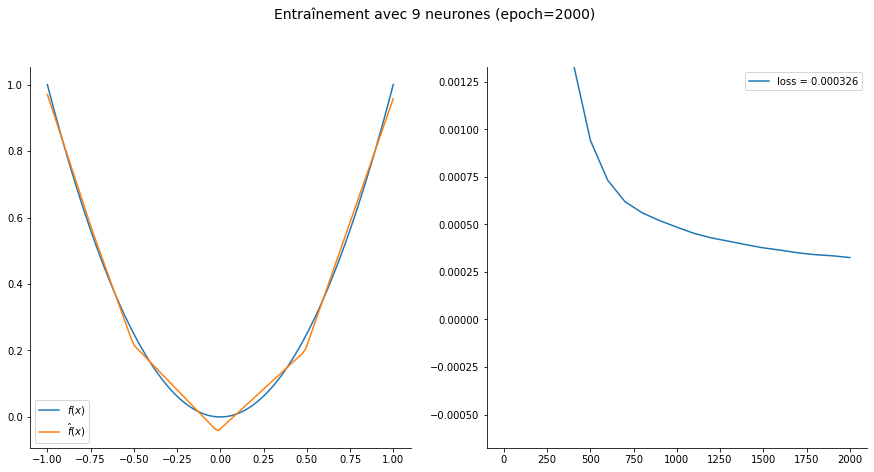

Entraînement terminé !


In [20]:
tf.random.set_seed(123)
N_EVAL = 100  # toutes les N époques on evalue et on affiche le résultat obtenu
list_loss = []

# Configurations
EPOCHS = 2000  # nombre d'itérations sur le jeu de données X
BATCH_SIZE = 10  # taille du batch (m)
N_NEURONS = 9  # nombre de neurones dans la couche cachée

# Il est possible de mélanger les données à chaque époque (voir fonction shuffle ci-dessous)
# Dans ce cas, on initialise la graine pour cette permutation aléatoire des données
seed_counter = 0

# Initialisation du réseau de neurones et de la fonction d'optimisation
model = build_model(dim_data=1, n_neurons=N_NEURONS)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)

data_train = [X, y]

# Boucle d'entraînement
for epoch in range(1, EPOCHS+1):
    # Si on veut mélanger les données à chaque époque, decommenter le code ci-dessous:
    # seed_counter +1
    # data_train = shuffle(X, y, random_state=seed_counter)

    data_batches = tf.data.Dataset.from_tensor_slices(data_train).batch(BATCH_SIZE)
    
    for data_batch in data_batches:
        X_batch, y_batch = data_batch
        loss_value, gradients = train_step(model, X_batch, y_batch)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    # Toutes le N_EVAL époques on evalue et on affiche le résultat intermédiaire
    if (epoch) % N_EVAL == 0 or epoch == 1: 
        loss_value, _ = train_step(model, X, y)  # sur toutes les données
        list_loss.append(loss_value)
        y_pred = model(X)
        
        display.clear_output(wait=True)
        fig = plt.figure(figsize=(15, 7))
        gs = GridSpec(1, 2, figure=fig)

        ax1 = fig.add_subplot(gs[0, 0])
        ax2 = fig.add_subplot(gs[0, 1])
        
        # On affiche la fonction \hat{f} obtenue 
        ax1.plot(X, y, label="$f(x)$")
        ax1.plot(X, y_pred, label="$\hat{f}(x)$")
        ax1.legend()
        sns.despine()
        
        # On affiche l'évaluation de la fonction de cout
        ax2.plot(np.linspace(1, (len(list_loss) - 1) * N_EVAL, len(list_loss)), 
                 list_loss, label="loss = {:.6f}".format(loss_value))
        ax2.set_ylim(loss_value - 1e-3, loss_value + 1e-3)
        ax2.legend()
        sns.despine()
        
        fig.suptitle("Entraînement avec {} neurones (epoch={})".format(N_NEURONS, epoch), size=14, y=1.)
        
        plt.show()

print("Entraînement terminé !")

**Relancer l'entraînement en augmentant le nombre de neurones. Que pouvez-vous observer?**